In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras.api._v2.keras as keras
from keras import mixed_precision
import numpy as np
import matplotlib.pyplot as plt

2023-06-29 02:33:14.691154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 02:33:14.789638: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

mirrored_strategy = tf.distribute.MirroredStrategy()

# mixed_precision.set_global_policy('mixed_float16')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-06-29 02:33:16.887126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 02:33:18.136256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38289 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0
2023-06-29 02:33:18.137954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31749 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:d8:00.0, compute capability: 8.0


In [3]:
path = "../mnist/cmnist/fgbg_cmnist_cpr0.5-0.5/"
mnist_train = tf.convert_to_tensor(np.load(path + "colored_mnist_init_train.npy") * 255)
mnist_test = tf.convert_to_tensor(np.load(path + "colored_mnist_init_test.npy") * 255)
mnist_train_target = tf.convert_to_tensor(
    np.load(path + "colored_mnist_target_train.npy")
)
mnist_test_target = tf.convert_to_tensor(
    np.load(path + "colored_mnist_target_test.npy")
)

mnist_train = tf.transpose(mnist_train, [0, 2, 3, 1])
mnist_test = tf.transpose(mnist_test, [0, 2, 3, 1])

print(mnist_train.shape, mnist_test.shape)
print(mnist_train_target.shape, mnist_test_target.shape)

train_data = tf.data.Dataset.from_tensor_slices(((mnist_train, mnist_train_target),))

batch_size = 128
train_data = train_data.shuffle(10000).batch(batch_size)

(60000, 28, 28, 3) (10000, 28, 28, 3)
(60000, 7) (10000, 7)


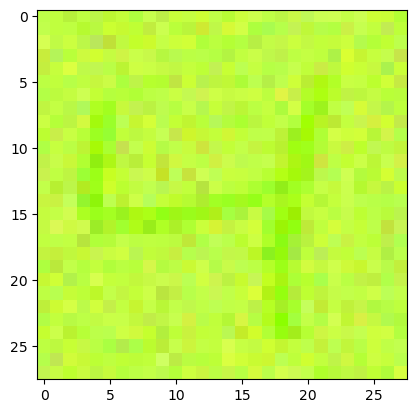

In [19]:
plt.imshow(mnist_train[2] / 255)
plt.show()

In [5]:
image_shape = (28, 28, 3)
label_shape = (7,)
with mirrored_strategy.scope():
    dist = tfp.distributions.PixelCNN(
        image_shape=image_shape,
        conditional_shape=label_shape,
        num_resnet=2,
        num_hierarchies=3,
        num_filters=128,
        num_logistic_mix=10,
        dropout_p=0.3,
    )

    image_input = keras.layers.Input(shape=image_shape)
    label_input = keras.layers.Input(shape=label_shape)

    log_prob = dist.log_prob(image_input, conditional_input=label_input)

    class_cond_model = keras.Model(inputs=[image_input, label_input], outputs=log_prob)
    class_cond_model.add_loss(-tf.reduce_mean(log_prob))

    class_cond_model.compile(optimizer=keras.optimizers.Adam(), metrics=[])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [6]:
class_cond_model.fit(train_data, epochs=5)

2023-06-29 02:33:55.304557: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 60000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
        dim {
          size: 3
        }
      }
      shape {
        dim {
          size: 7
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experi

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 326 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 326 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-06-29 02:34:52.828883: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-29 02:34:53.073153: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2023-06-29 02:34:54.412138: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800


469/469 [==============================] - 150s 183ms/step - loss: 8231.7803
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 2/5
469/469 [==============================] - 83s 178ms/step - loss: 8120.3999
Epoch 3/5
469/469 [==============================] - 84s 179ms/step - loss: 7750.4688
Epoch 4/5
469/469 [==============================] - 84s 178ms/step - loss: 7738.6353
Epoch 5/5
469/469 [==============================] - 84s 179ms/step - loss: 7699.8896


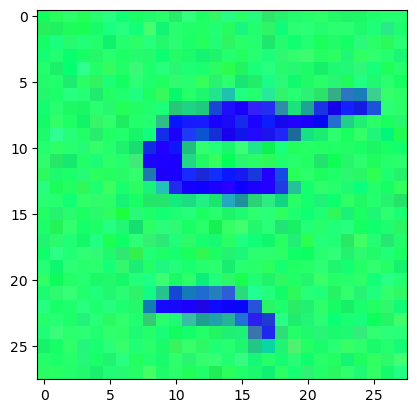

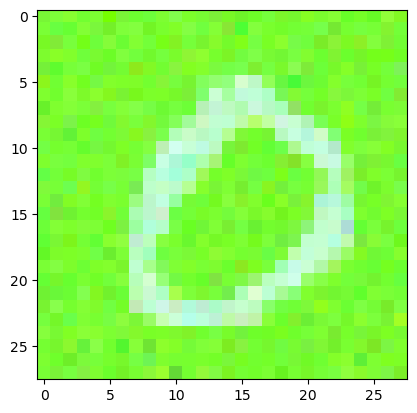

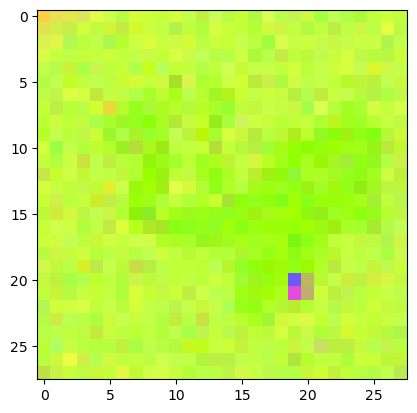

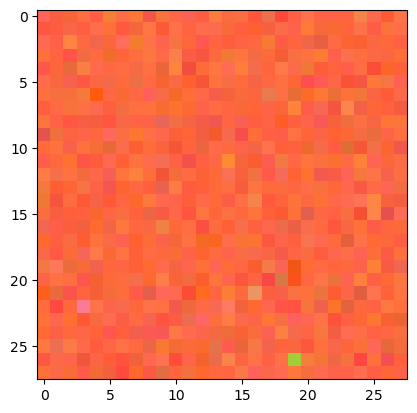

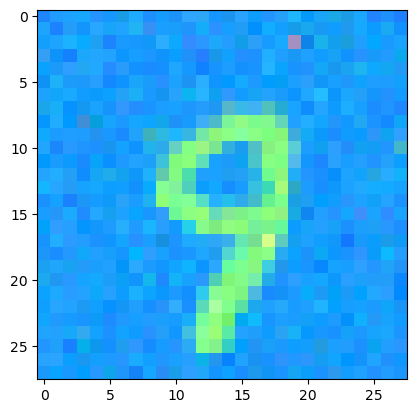

In [7]:
samples = dist.sample(5, conditional_input=mnist_train_target[:5, :])

for i in range(5):
    plt.imshow(samples[i, :] / 255)
    plt.show()

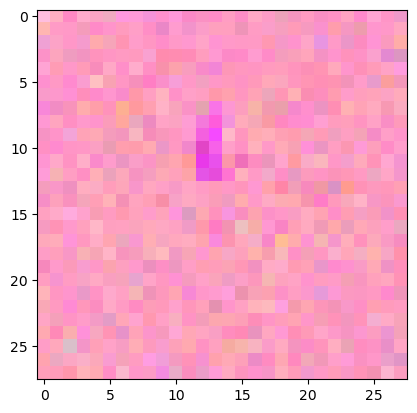

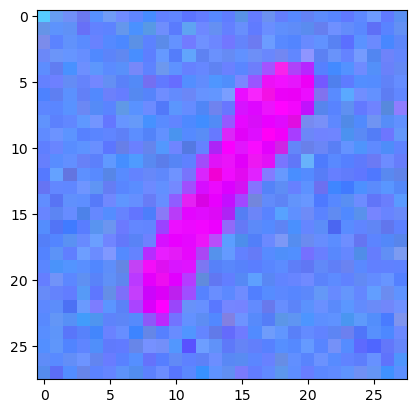

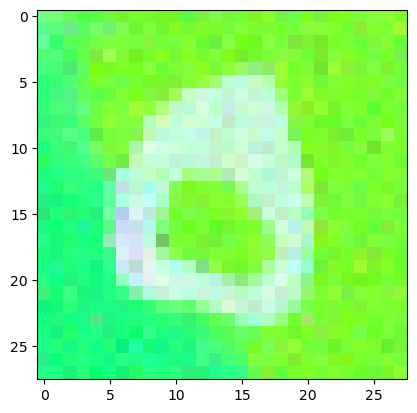

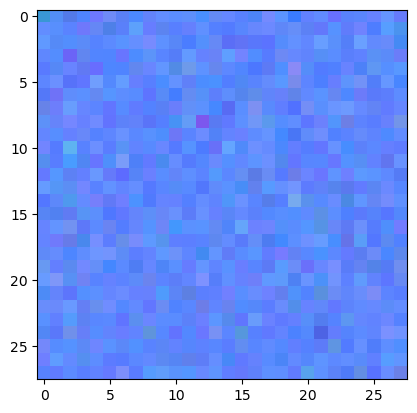

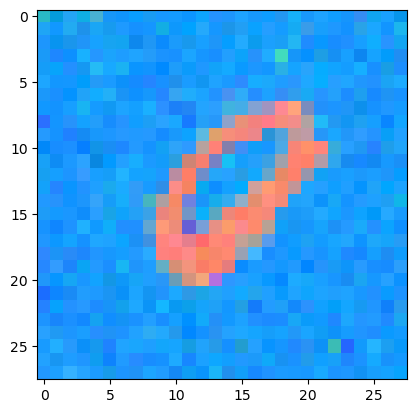

In [8]:
samples = dist.sample(5, conditional_input=mnist_test_target[:5, :])

for i in range(5):
    plt.imshow(samples[i, :] / 255)
    plt.show()